# <b>Plant Seedlings Classification Project 2 
# **PART 1**
Pablo Aguirre Solana

## **Objective**

### <font color ='red'>**Create a classifier capable of determining a plant's species from an image**</font>


### **Importing the necessary libraries**

In [1]:
import os
import numpy as np                                                                              
import pandas as pd                                                                              
import matplotlib.pyplot as plt                                                                  
import math                                                                                    
import cv2                                                                                      
import seaborn as sns                                                                            


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              
from tensorflow.keras.models import Sequential                                                   
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization 
from tensorflow.keras.optimizers import Adam,SGD                                                
from sklearn import preprocessing                                                                
from sklearn.model_selection import train_test_split                                             
from sklearn.metrics import confusion_matrix                                                    

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                     

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### **Reading the dataset**

In [10]:
images = np.load("/images.npy")

In [11]:
labels = pd.read_csv("/Labels.csv")

#### **Overview of the dataset**

In [12]:
print(images.shape)        
print(labels.shape)         

(4750, 128, 128, 3)
(4750, 1)


**Observations**

- We can see that the data sets contains 4750 images, with pixel sizes 128 x 128 and three channel color.
- Regarding the Label file we can see from its shape that it has 4750 lables in one column.
- Due to the large size of the images, this were transformed into numpy arrays, and the corresponding labels put into a csv file.

In [13]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)        

## **Exploratory Data Analysis** 

In [14]:
def plot_images(images,labels):
  num_classes=10                                                                 
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      
  rows = 3                                                                        
  cols = 4                                                                        
  fig = plt.figure(figsize=(10, 8))                                              
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      
          ax.imshow(images[random_index, :])                                    
          ax.set_title(keys[random_index])
  plt.show()

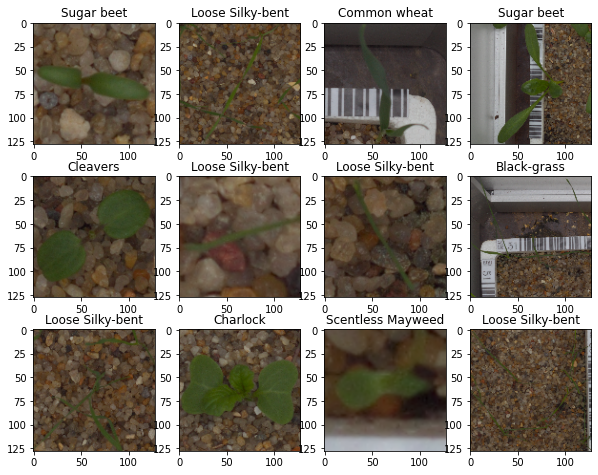

In [ ]:
plot_images(images,labels)   

**Observations**

- From the actual sizes of the images, there is some blurring of the images and they are not close enough. Some data augmentation will be needed in order to increase the size and do some geometric transformations to avoid overfitting and improve model performance.

<b> Checking for data imbalance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

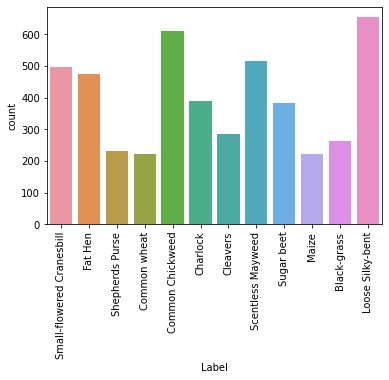

In [15]:
sns.countplot(labels['Label'])            
plt.xticks(rotation='vertical')

**Observations**

- We can see that there is some imbalance among the classes, that is; the data set does not contain the same number of cases for each class. 
- It is clear form the plot that some classes are over-represented, such as "Loose Silky-bent" and some are under-represented such as, "Sheperds Purse" and "Common wheat".
- Having an imblanaced data set can affect the final prediction and the performance of the classification model.

### <b>Resizing images 


In [16]:
images_decreased=[]
height = 64                   
width =  64                
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

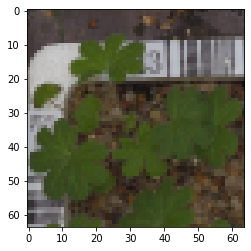

In [17]:
plt.imshow(images_decreased[3])

### **Splitting the dataset**




In [18]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),np.array(labels) , test_size= 0.1, random_state=42,stratify=labels)   
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)                      

In [19]:
# Complete the code to check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


**Observations**

- The data set is divided in three distinct samples for crossvalidation; training, validation and test sampling. This is done mainly to prevent overfitting and to avoid the common problem which is;  that a model can be pretty good at classifying the samples in the training set, but cannot generalize and make good classification on unseen data (test set).
- From the splitting above we can see that we end up with three samples with sizes; 3847, 428 and 475, all with image sizes 64x64 in three channels. The same proportion is applied for the labels file.

## Encoding the target labels

In [20]:
# Convert labels from names to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()                                        
y_train_encoded = enc.fit_transform(y_train)        
y_val_encoded= enc.transform(y_val)                  
y_test_encoded= enc.transform(y_test)                

In [21]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape    

((3847, 12), (428, 12), (475, 12))

## Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [22]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Observations**

- The reason that we use the Label Binarizer is that when we have multiple labels for a different classes in a variable these cannot be trained in a Machine Learning model, that is; we have to transform those labels into numbers (numerical inputs) in order for the algorithms to work. Label Binarizer is different from one hot encoding, because it reduces the sparsity of the data compared to one hot encoder
- It is also critical to normalize the data, because it standarizes the value of each image between 0 and 1, this helps us avoid getting stuck at local optima and to avoid exploding gradient problems. Finally it makes the training faster.

## **Model Building - Convolutional Neural Network (CNN)**

In [23]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [24]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## **CNN Model 1**


In [ ]:
model1 = Sequential()                             

model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Flatten())

  
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3)) 
model1.add(Dense(12, activation='softmax'))

opt=Adam()
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

### <b> Fitting the model on the train data

In [ ]:
#Fitting the model
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

### **Model Evaluation**

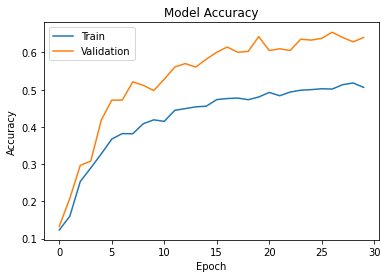

In [27]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Evaluate the model on test data**

In [28]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)    

15/15 - 0s - loss: 1.1355 - accuracy: 0.6000 - 230ms/epoch - 15ms/step


### **Plotting the Confusion Matrix**




In [29]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)                          # Complete the code to predict the output probabilities

15/15 [==============================] - 0s 5ms/step


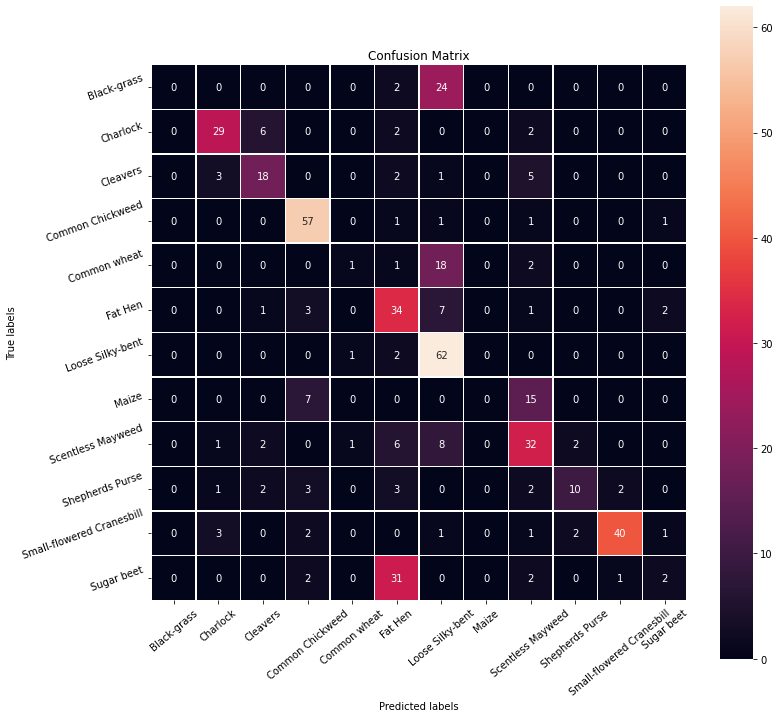

In [30]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)              # Complete the code to plot the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

### **Plotting Classification Report**

In [31]:
# Plotting the classification report 
from sklearn.metrics import classification_report
cr=classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.78      0.74      0.76        39
           2       0.62      0.62      0.62        29
           3       0.77      0.93      0.84        61
           4       0.33      0.05      0.08        22
           5       0.40      0.71      0.52        48
           6       0.51      0.95      0.66        65
           7       0.00      0.00      0.00        22
           8       0.51      0.62      0.56        52
           9       0.71      0.43      0.54        23
          10       0.93      0.80      0.86        50
          11       0.33      0.05      0.09        38

    accuracy                           0.60       475
   macro avg       0.49      0.49      0.46       475
weighted avg       0.54      0.60      0.54       475



**Observations**

- The first model is a pretty simple model with few layers and with NO Data Augmentation, Batch Normalization and Spatial Dropout, techniques that address overfiting. 
- Hence, our first model has a low overall accuracy of .60, this means that out of 10 images it will only correctly classify 6. This can be seen in the confusion matrix, which tells us visually the number of classes that are correctly and inccorrectly classified.
- The overfitting pattern for this model can be observed in the plot of "Model Accuracy" by which the accuracy curve of the validation sample splits significantly from the accuracy curve of the training sample. 

In [ ]:
del model1
del history_1     

# **Improving the Base Model using Data Augmentation and Regularization**




In [32]:
from keras.callbacks import ReduceLROnPlateau

# Complete the code to monitor val_accuracy 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


### **Data Augmentation**

In [33]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [34]:
train_datagen = ImageDataGenerator(
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode = 'nearest')

In [ ]:
# Intializing a sequential model
model2 = Sequential()


model2.add(Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.30))
model2.add(Dense(12, activation='softmax'))

model2.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary() 

In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

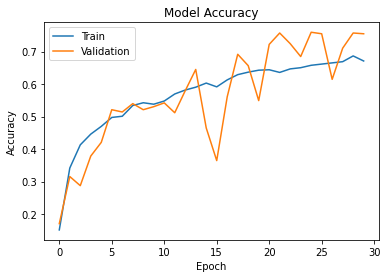

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  

15/15 - 0s - loss: 0.8804 - accuracy: 0.7347 - 146ms/epoch - 10ms/step


In [39]:
# Output probabilities
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


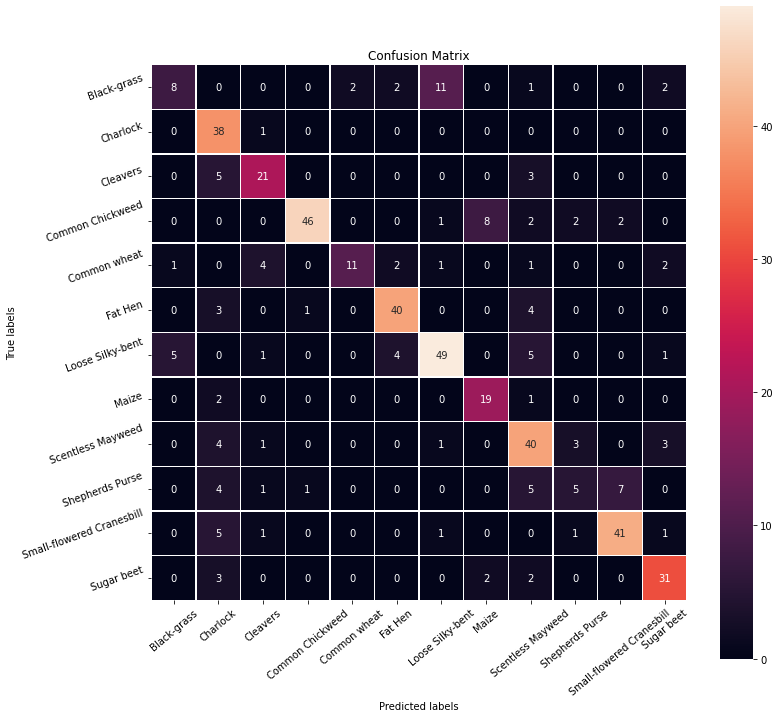

In [40]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [42]:
# Plotting the classification report 
from sklearn.metrics import classification_report
cr=classification_report(y_test_arg,y_pred_arg)     
print(cr)

              precision    recall  f1-score   support

           0       0.57      0.31      0.40        26
           1       0.59      0.97      0.74        39
           2       0.70      0.72      0.71        29
           3       0.96      0.75      0.84        61
           4       0.85      0.50      0.63        22
           5       0.83      0.83      0.83        48
           6       0.77      0.75      0.76        65
           7       0.66      0.86      0.75        22
           8       0.62      0.77      0.69        52
           9       0.45      0.22      0.29        23
          10       0.82      0.82      0.82        50
          11       0.78      0.82      0.79        38

    accuracy                           0.73       475
   macro avg       0.72      0.69      0.69       475
weighted avg       0.74      0.73      0.73       475



## **Visualizing the prediction:**

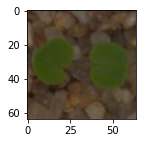

1/1 [==============================] - 0s 66ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


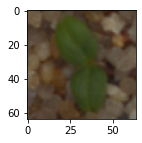

1/1 [==============================] - 0s 16ms/step
Predicted Label ['Cleavers']
True Label Cleavers


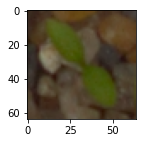

1/1 [==============================] - 0s 22ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


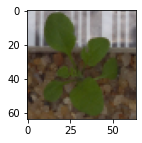

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Shepherds Purse


In [43]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

**Observations**

- The second model was performed using data augmentation, and batch normalization for one layer. 
- The overall accuracy for the model improved from .60 to .73, this improvement can be attributable to the data augmentation and batch normalization.
- This model compared to the first one, does not present overfitting and does generalizes better on the test data.
- Still there are some classes that are not so well classified, as we can see from the confusion matrix and from the classification report that classes; 0,1,8 and 9, have low precision scores.

